In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import itertools
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv("DLL_COVID_TRAIN.csv", parse_dates=["dateRep"])

In [3]:
dataset.head()

,countryterritoryCode,dateRep,cases,deaths,countriesAndTerritories,popData2018,GDP (current US$),GDP per capita (current US$),Access to electricity (% of population),Current health expenditure per capita (current US$),Current health expenditure (% of GDP),"Hospital beds (per 1,000 people)"
0,AFG,2020-04-17,10,4,Afghanistan,37172386.0,1.936297e+10,520.896603,97.7,67.12265,11.777194,0.5
1,AFG,2020-04-16,70,2,Afghanistan,37172386.0,1.936297e+10,520.896603,97.7,67.12265,11.777194,0.5
2,AFG,2020-04-15,49,2,Afghanistan,37172386.0,1.936297e+10,520.896603,97.7,67.12265,11.777194,0.5
3,AFG,2020-04-14,58,3,Afghanistan,37172386.0,1.936297e+10,520.896603,97.7,67.12265,11.777194,0.5
4,AFG,2020-04-13,52,0,Afghanistan,37172386.0,1.936297e+10,520.896603,97.7,67.12265,11.777194,0.5


In [4]:
dataset = dataset.sort_values("dateRep")

In [5]:
forcast_days = 7
split_date = dataset["dateRep"].max() - np.timedelta64(forcast_days, "D")

In [6]:
train_df = dataset.loc[dataset["dateRep"] < split_date]
test_df = dataset.loc[dataset["dateRep"] >= split_date]

In [7]:
train_df.describe()

,cases,deaths,popData2018,GDP (current US$),GDP per capita (current US$),Access to electricity (% of population),Current health expenditure per capita (current US$),Current health expenditure (% of GDP),"Hospital beds (per 1,000 people)"
count,9626.000000,9626.000000,9.607000e+03,9.390000e+03,9390.000000,9440.000000,8966.000000,8966.000000,9185.000000
mean,153.346354,9.122065,6.361825e+07,8.430790e+11,25128.295292,92.970108,1788.721743,6.865349,3.473547
std,1190.172484,75.314339,2.001526e+08,2.608225e+12,30322.567348,17.922541,2287.713332,2.773843,2.852989
min,0.000000,0.000000,1.000000e+03,4.222968e+08,271.752044,9.300000,19.431646,1.181210,0.100000
25%,0.000000,0.000000,3.731000e+06,2.454247e+10,4114.715061,99.506447,204.492249,4.748105,1.500000
50%,0.000000,0.000000,1.062570e+07,1.406454e+11,11373.233003,100.000000,587.646301,6.541954,2.800000
75%,14.000000,0.000000,4.222843e+07,4.549676e+11,41715.029284,100.000000,2840.130615,8.873130,4.600000
max,34272.000000,2004.000000,1.392730e+09,2.054434e+13,185741.279992,100.000000,10246.138672,17.061269,18.680000


In [8]:
train_df.isna().sum(axis=0)

countryterritoryCode                                     0
dateRep                                                  0
cases                                                    0
deaths                                                   0
countriesAndTerritories                                  0
popData2018                                             19
GDP (current US$)                                      236
GDP per capita (current US$)                           236
Access to electricity (% of population)                186
Current health expenditure per capita (current US$)    660
Current health expenditure (% of GDP)                  660
Hospital beds (per 1,000 people)                       441
dtype: int64

### Fill nans with zeros

In [9]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

### Fitting LSTM model to the one country time series series

In [10]:
country = "Italy"

In [11]:
timeseries = train_df[
    train_df["countriesAndTerritories"] == country
]  # ["cases"].tolist()

In [12]:
test_one_country = test_df[test_df["countriesAndTerritories"] == country]

In [13]:
input_size = (
    len(train_df.columns) - 3
)  # we don't use countryterritoryCode, dateRep, and countriesAndTerritories
hidden_size = 10
num_layers = 1

In [14]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


class train_dataset(Dataset):
    def __init__(self, df: pd.DataFrame, length: int = 7):
        self.df = df.copy().drop(
            columns=["countryterritoryCode", "countriesAndTerritories"]
        )
        self.label_columns = ["cases", "deaths"]
        self.length = length

    def __len__(self):
        return len(self.df) - self.length + 1

    def __getitem__(self, idx):
        sample = self.df.iloc[idx: idx + self.length]

        cases = torch.tensor(sample.pop("cases").to_numpy()).float()
        cases = cases.unsqueeze(1)
        deaths = torch.tensor(sample.pop("deaths").to_numpy()).float()
        deaths = deaths.unsqueeze(1)

        date = sample.pop("dateRep")
        sample = torch.tensor(sample.to_numpy()).float()#[None, :]
        return sample, cases, deaths


class MSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return self.mse(torch.log(pred + 1e-8), torch.log(actual + 1e-8))


class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_lstm_layers: int):
        super().__init__()
        self.fc1 =  nn.Linear(input_size, 32)
        self.lstm = nn.LSTM(
            input_size=32, hidden_size=hidden_size, num_layers=num_lstm_layers
        )
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x, _ = self.lstm(x)
        y = F.relu(self.fc2(x))
        return y


def train_model(
    dataset: Dataset, model: nn.Module, epochs: int = 6, batch_size=32
) -> nn.Module:
    crierion = MSLELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for x, cases, deaths in dataloader:
            model.zero_grad()
            cases_pred = model(x)
            loss = crierion(cases_pred[-1], cases[-1])
            loss.backward()
            optimizer.step()
            print(loss)
            
    with torch.no_grad():
        print(cases_pred.detach().numpy(), cases)


In [15]:
timeseries["last_cases"] = timeseries["cases"].shift(1)
timeseries["last_cases"] = timeseries["last_cases"].fillna(0)
timeseries["last_deaths"] = timeseries["deaths"].shift(1)
timeseries["last_deaths"] = timeseries["last_deaths"].fillna(0)

In [16]:
lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_lstm_layers=num_layers)
train_ds = train_dataset(timeseries)
train_model(train_ds, lstm)

tensor(245.9985, grad_fn=<MseLossBackward>)
tensor(281.3477, grad_fn=<MseLossBackward>)
tensor(107.9191, grad_fn=<MseLossBackward>)
tensor(108.1400, grad_fn=<MseLossBackward>)
tensor(80.7840, grad_fn=<MseLossBackward>)
tensor(275.6723, grad_fn=<MseLossBackward>)
tensor(236.8925, grad_fn=<MseLossBackward>)
tensor(273.0522, grad_fn=<MseLossBackward>)
tensor(269.9863, grad_fn=<MseLossBackward>)
tensor(165.9465, grad_fn=<MseLossBackward>)
tensor(95.1197, grad_fn=<MseLossBackward>)
tensor(84.9289, grad_fn=<MseLossBackward>)
tensor(50.4604, grad_fn=<MseLossBackward>)
tensor(255.6067, grad_fn=<MseLossBackward>)
tensor(252.9649, grad_fn=<MseLossBackward>)
tensor(214.5064, grad_fn=<MseLossBackward>)
tensor(239.9033, grad_fn=<MseLossBackward>)
tensor(226.2612, grad_fn=<MseLossBackward>)
tensor(170.1409, grad_fn=<MseLossBackward>)
tensor(197.7975, grad_fn=<MseLossBackward>)
tensor(168.9862, grad_fn=<MseLossBackward>)
tensor(729.1535, grad_fn=<MseLossBackward>)
tensor(637.3875, grad_fn=<MseLossBac

In [48]:
train_ds[0], train_ds[1], 

((tensor([[6.0431e+07, 2.0839e+12, 3.4483e+04, 1.0000e+02, 2.8401e+03, 8.8403e+00,
           3.4000e+00],
          [6.0431e+07, 2.0839e+12, 3.4483e+04, 1.0000e+02, 2.8401e+03, 8.8403e+00,
           3.4000e+00],
          [6.0431e+07, 2.0839e+12, 3.4483e+04, 1.0000e+02, 2.8401e+03, 8.8403e+00,
           3.4000e+00],
          [6.0431e+07, 2.0839e+12, 3.4483e+04, 1.0000e+02, 2.8401e+03, 8.8403e+00,
           3.4000e+00],
          [6.0431e+07, 2.0839e+12, 3.4483e+04, 1.0000e+02, 2.8401e+03, 8.8403e+00,
           3.4000e+00],
          [6.0431e+07, 2.0839e+12, 3.4483e+04, 1.0000e+02, 2.8401e+03, 8.8403e+00,
           3.4000e+00],
          [6.0431e+07, 2.0839e+12, 3.4483e+04, 1.0000e+02, 2.8401e+03, 8.8403e+00,
           3.4000e+00]], dtype=torch.float64),
  tensor([0, 0, 0, 0, 0, 0, 0]),
  tensor([0, 0, 0, 0, 0, 0, 0]),
  5470   2019-12-31
  5469   2020-01-01
  5468   2020-01-02
  5467   2020-01-03
  5466   2020-01-04
  5465   2020-01-05
  5464   2020-01-06
  Name: dateRep, dtype

In [13]:
def MSLE_loss(one, two):
    loss = np.mean((np.log1p(one) - np.log1p(two)) ** 2)  # MSLE loss
    return loss


def run_arima(train, test, order):
    model = ARIMA(train, order=order)
    model = model.fit(disp=0)
    predictions = model.forecast(steps=len(test))[0]
    loss = MSLE_loss(test, predictions)  # MSLE loss
    return loss


def evaluate_arima_params(train, test, p_list, d_list, q_list, verbose=0):
    best_loss, best_params = float("inf"), (0, 0, 0)
    for params in itertools.product(p_list, d_list, q_list):
        try:
            loss = run_arima(train, test, params)
            if loss < best_loss:
                best_loss, best_params = loss, params
        except:
            continue

    if verbose > 0:
        print(f"Best ARIMA params {best_params} with loss={best_loss}")
    return best_loss, best_params

In [14]:
run_arima(timeseries, test_one_country["cases"], (1, 0, 1))

0.028478075717193796

In [15]:
loss, params = evaluate_arima_params(
    timeseries, test_one_country["cases"], [0, 1, 2], [0, 1, 2], [0, 1, 2], verbose=1
)

/root/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/root/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA params (1, 0, 2) with loss=0.02806542308488452


In [16]:
model = ARIMA(timeseries, order=params)

In [17]:
model = model.fit(disp=False)

In [18]:
preds = model.forecast(steps=len(test_one_country))[0]

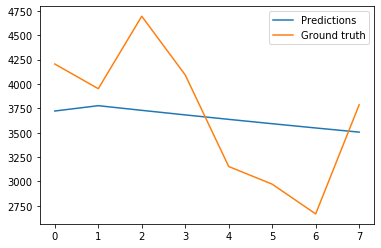

In [19]:
plt.plot(preds, label="Predictions")
plt.plot(test_one_country["cases"].tolist(), label="Ground truth")
plt.legend()

### Run this on all countries

In [20]:
country_list = dataset["countriesAndTerritories"].unique()

In [21]:
loss, params = evaluate_arima_params(
    timeseries, test_one_country["cases"], [0, 1, 2], [0, 1, 2], [0, 1, 2]
)

/root/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/root/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Next cell will take few minutes:

In [22]:
%%capture
predictions = pd.DataFrame()
for country in country_list:
    timeseries = train[train["countriesAndTerritories"] == country]["cases"].tolist()
    test_one_country = test[test["countriesAndTerritories"] == country]
    if len(test_one_country) == 0:
        print(f"There is no test data for {country}")
        continue
    loss, params = evaluate_arima_params(
        timeseries, test_one_country["cases"], [0, 1, 2], [0, 1, 2], [0, 1, 2]
    )
    if len(timeseries) == 0:
        preds = 0 * len(test_one_country)
    elif len(timeseries) < len(test_one_country):
        preds = timeseries[-1] * len(test_one_country)
    else:
        model = ARIMA(timeseries, order=params)
        model = model.fit(disp=False)
        preds = model.forecast(steps=len(test_one_country))[0]
    test_one_country["predictions"] = preds
    predictions = predictions.append(test_one_country)

### Score on cases:

In [23]:
MSLE_loss(predictions["cases"], predictions["predictions"])

0.6059281011533988